In [1]:
import random

import deepquantum as dq
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

random.seed(43)
np.random.seed(43)
torch.manual_seed(43)



In [2]:
class Y1Dataset(Dataset):
    def __init__(self, omega, a):
        """
        Args:
            omega (tensor): A tensor of omega values.
            a (tensor): A complex number representing the amplitude.
        """
        self.x_values = torch.linspace(-6, 6, 600).view(-1, 1)  # 2D tensor with shape (num_samples, 1)
        self.y_values = self.y1(self.x_values, omega, a)

    def y1(self, x, omega, a):
        sum_result = torch.zeros_like(x, dtype=torch.complex64)
        for w in omega:
            sum_result += a * torch.exp(1j * w * x) + torch.conj(a) * torch.exp(-1j * w * x)
        return sum_result.real

    def __len__(self):
        return len(self.x_values)

    def __getitem__(self, idx):
        return self.x_values[idx], self.y_values[idx]





class Y2Dataset(Dataset):
    def __init__(self, omega, amps):
        """
        Args:
            omega (tensor): A tensor of omega values.
            amps (tensor): A tensor of complex numbers representing the amplitudes.
        """
        self.x_values = torch.linspace(-6, 6, 600).view(-1, 1)  # 2D tensor with shape (num_samples, 1)
        self.y_values = self.y2(self.x_values, omega, amps)

    def y2(self, x, omega, amps):
        sum_result = torch.zeros_like(x, dtype=torch.complex64)
        for w, a in zip(omega, amps):
            sum_result += a * torch.exp(1j * w * x) + torch.conj(a) * torch.exp(-1j * w * x)
        return sum_result.real

    def __len__(self):
        return len(self.x_values)

    def __getitem__(self, idx):
        return self.x_values[idx], self.y_values[idx]

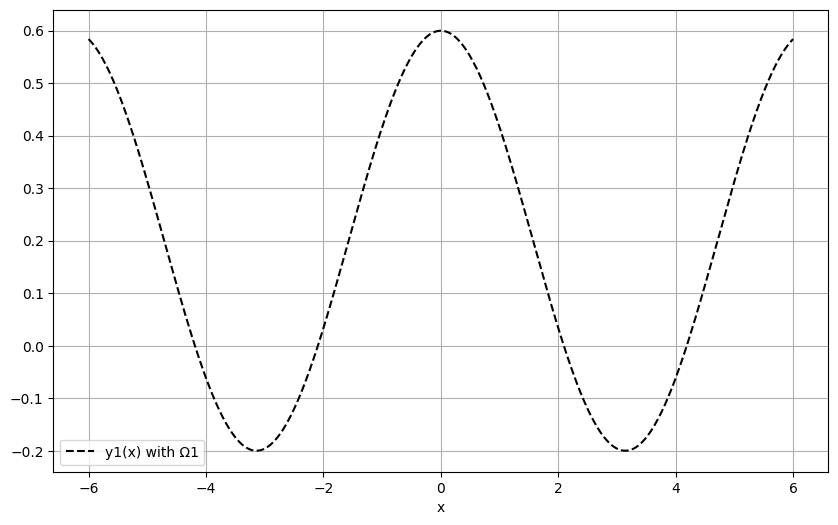

In [3]:
# Example usage:
omega1 = torch.tensor([0.0, 1.0, -1.0])
a = torch.tensor(0.1)
dataset_y1_omega1 = Y1Dataset(omega1, a)


# Plot
plt.figure(figsize=(10, 6))
plt.plot(dataset_y1_omega1.x_values.flatten().numpy(), dataset_y1_omega1.y_values.flatten().numpy(), 'k--', label='y1(x) with Ω1')
plt.xlabel('x')
plt.legend()
plt.grid(True)
plt.show()

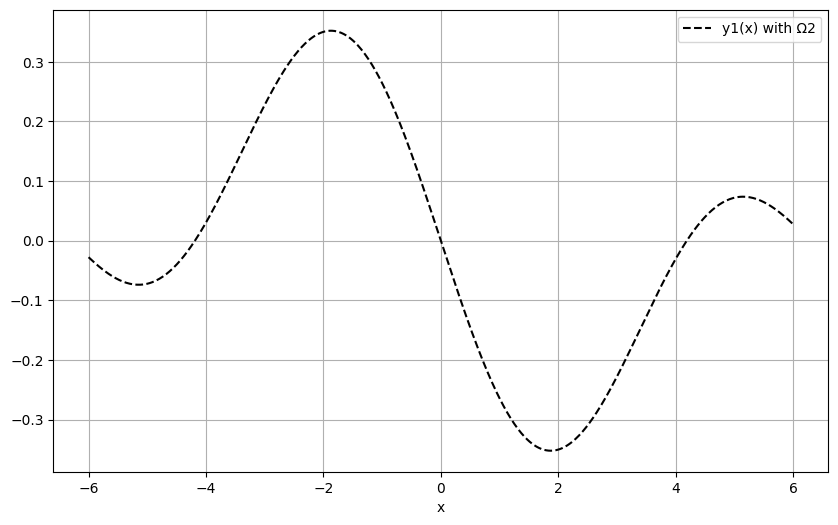

In [4]:
# Example usage:
omega2 = torch.tensor([0.0, 1.0, 0.5])
a = torch.tensor(0.1j)
dataset_y1_omega2 = Y1Dataset(omega2, a)


# Plot
plt.figure(figsize=(10, 6))
plt.plot(dataset_y1_omega2.x_values.flatten().numpy(), dataset_y1_omega2.y_values.flatten().numpy(), 'k--', label='y1(x) with Ω2')
plt.xlabel('x')
plt.legend()
plt.grid(True)
plt.show()

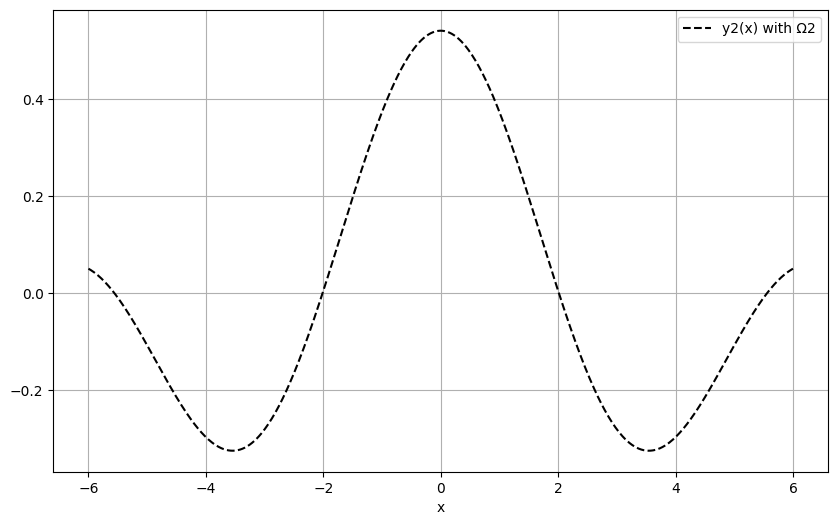

In [5]:
# Example usage:
omega2 = torch.tensor([0.0, 1.0, 0.5])
amps = torch.tensor([0.1j,0.15, 0.12]) # 并非所有的系数都能拟合，取决于变分线路
dataset_y2_omega2 = Y2Dataset(omega2, amps)


# Plot
plt.figure(figsize=(10, 6))
plt.plot(dataset_y2_omega2.x_values.flatten().numpy(), dataset_y2_omega2.y_values.flatten().numpy(), 'k--', label='y2(x) with Ω2')
plt.xlabel('x')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def get_loader(dataset, split_ratio=0.8, batch_size=8):
    # Splitting the dataset into training and validation datasets
    train_size = int(split_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # You can now use DataLoader to load these datasets if needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [7]:
get_loader(dataset_y1_omega1)

(<torch.utils.data.dataloader.DataLoader at 0x7742e37b3eb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7742e37b3bb0>)

In [8]:
class QNN(nn.Module):
    def __init__(self, residual=False):
        super().__init__()
        self.residual = residual
        if residual:
            self.qnn = dq.QubitCircuit(2)
            self.qnn.u3(wires=1)
            self.qnn.ry(wires=0)
            self.qnn.ry(wires=1, encode=True, controls=0)
            self.qnn.ry(wires=0)
            self.qnn.u3(wires=1)
            self.qnn.observable(wires=1, basis='z')
            self.qnn.observable(wires=[0, 1], basis='zz')
        else:
            self.qnn = dq.QubitCircuit(1)
            self.qnn.u3(wires=0)
            self.qnn.ry(wires=0, encode=True)
            self.qnn.u3(wires=0)
            self.qnn.observable(wires=0, basis='z')
    def forward(self, x):
        state = self.qnn(data=x)
        exp = self.qnn.expectation()
        if self.residual:
            exp = (exp[:, [0]] + exp[:, [1]])/2
        else:
            exp = exp
        return exp

In [9]:
def train_model(epochs, model, dataset):
    train_loader, val_loader = get_loader(dataset)
    opt = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        # Training phase
        model.train()  # Set the model to training mode
        for j, (x, y) in enumerate(train_loader):
            yhat = model(x)
            loss = torch.nn.functional.mse_loss(yhat, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            if epoch==0: print(loss.item())

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for j, (x, y) in enumerate(val_loader):
                yhat = model(x)
                loss = torch.nn.functional.mse_loss(yhat, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print('Validation - Epoch', epoch, 'Average Valid Loss:', avg_val_loss)

    return model


In [10]:
def plot_predictions(dataset, label_dataset, trained_model, label_model):
    if not isinstance(trained_model, list):
        # Generate predictions using the model
        trained_model.eval()
        with torch.no_grad():
            predictions = trained_model(dataset.x_values).flatten().numpy()

        # Plot the original y(x) and the predictions
        plt.figure(figsize=(10, 6))
        plt.plot(dataset.x_values.flatten().numpy(), dataset.y_values.flatten().numpy(), 'k--', label=label_dataset, zorder=2)
        plt.plot(dataset.x_values.flatten().numpy(), predictions, 'gray', linewidth=6, label=label_model, zorder=1)
    else:
        # Plot the original y(x) and the predictions
        plt.figure(figsize=(10, 6))
        plt.plot(dataset.x_values.flatten().numpy(), dataset.y_values.flatten().numpy(), 'k--', label=label_dataset, zorder=2)
        for model, label in zip(trained_model, label_model):
            model.eval()
            with torch.no_grad():
                predictions = model(dataset.x_values).flatten().numpy()
            if 'residual' in label:
                color = 'red'
            elif 'traditional' in label:
                color = 'gray'
            plt.plot(dataset.x_values.flatten().numpy(), predictions, color, linewidth=6, label=label, zorder=1)



    plt.xlabel('x')
    plt.legend()
    plt.grid(True)
    plt.show()

# 实验1（dataset_y1_omega1）

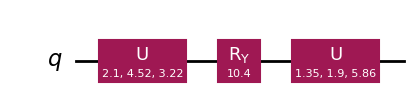

In [11]:
qnn_traditional = QNN(residual=False)
qnn_traditional.qnn.draw()


In [12]:
trained_qnn_traditional = train_model(epochs=30, model=qnn_traditional, dataset=dataset_y1_omega1)

0.32793760299682617
0.18773628771305084
0.17897795140743256
0.1405051052570343
0.09296046197414398
0.21029016375541687
0.15223199129104614
0.19843433797359467
0.11480169743299484
0.15322643518447876
0.14357726275920868
0.13207027316093445
0.11197618395090103
0.14177779853343964
0.09086906164884567
0.060897715389728546
0.07009849697351456
0.10629097372293472
0.10314016789197922
0.11562545597553253
0.07891513407230377
0.061751678586006165
0.04402115195989609
0.05088553577661514
0.06436586380004883
0.050191037356853485
0.04192167520523071
0.054841335862874985
0.02407860942184925
0.02830122783780098
0.030485861003398895
0.027371838688850403
0.016908816993236542
0.03181272745132446
0.019355470314621925
0.012996618635952473
0.013626005500555038
0.015478371642529964
0.016547510400414467
0.01019574049860239
0.009016331285238266
0.01299180556088686
0.01334443874657154
0.0070923068560659885
0.00443953787907958
0.005379472393542528
0.004603763576596975
0.0031857790891081095
0.0016949618002399802


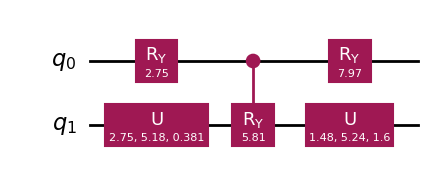

In [13]:
qnn_residual = QNN(residual=True)
qnn_residual.qnn.draw()

In [14]:
trained_qnn_residual = train_model(epochs=30, model=qnn_residual, dataset=dataset_y1_omega1)

0.2498665750026703
0.416174054145813
0.09635421633720398
0.26993250846862793
0.2625477612018585
0.1196589544415474
0.09246129542589188
0.21263062953948975
0.11880902200937271
0.24978257715702057
0.1941917985677719
0.18533872067928314
0.11015422642230988
0.06863939762115479
0.19233614206314087
0.17446202039718628
0.1501626819372177
0.12399959564208984
0.1689424365758896
0.12528976798057556
0.126775860786438
0.11290938407182693
0.1271500587463379
0.11645083129405975
0.07235758006572723
0.1657189279794693
0.13342173397541046
0.12267836183309555
0.1354982554912567
0.10212042927742004
0.1429719179868698
0.17870210111141205
0.08159516006708145
0.15524542331695557
0.05865252763032913
0.12150948494672775
0.07999113947153091
0.10583445429801941
0.10432383418083191
0.09013284742832184
0.12244115024805069
0.1066230982542038
0.0497211255133152
0.06453750282526016
0.12223131954669952
0.1560102105140686
0.08467964082956314
0.09834737330675125
0.05198607221245766
0.06378422677516937
0.068127676844596

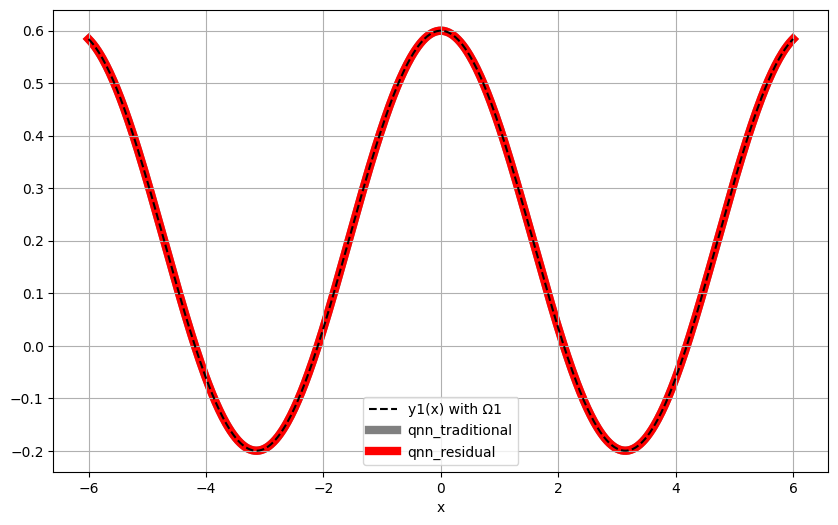

In [15]:
plot_predictions(dataset_y1_omega1,  label_dataset='y1(x) with Ω1',
                 trained_model=[trained_qnn_traditional, trained_qnn_residual],
                 label_model=['qnn_traditional', 'qnn_residual'])


# 实验2（dataset_y1_omega2）

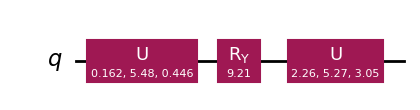

In [16]:
qnn_traditional = QNN(residual=False)
qnn_traditional.qnn.draw()


In [17]:
trained_qnn_traditional = train_model(epochs=30, model=qnn_traditional, dataset=dataset_y1_omega2)

0.9350706934928894
0.9428850412368774
0.8695932626724243
0.6667467951774597
0.4615615904331207
0.8245344758033752
0.942587673664093
0.7688193917274475
0.8209993243217468
0.5450986623764038
0.6687362194061279
0.5470566749572754
0.663469672203064
0.595554530620575
0.5364326238632202
0.9462630152702332
0.7446591854095459
0.5961485505104065
0.7795305848121643
0.5881326198577881
0.8356995582580566
0.5400883555412292
0.5083482265472412
1.0024709701538086
0.6091222167015076
0.5541707873344421
0.6144770979881287
0.4693310260772705
0.9151529669761658
1.0538264513015747
0.5673255920410156
0.6143959164619446
1.0214496850967407
0.6331475377082825
0.6844220161437988
0.5126935243606567
0.2731865346431732
0.4056703746318817
0.8365101218223572
0.5361462831497192
0.899013102054596
0.6738793849945068
0.4635762870311737
0.794120192527771
0.3336881995201111
0.42500370740890503
0.6147435307502747
0.5876359343528748
0.7389954924583435
0.5779211521148682
0.7356974482536316
0.5414594411849976
0.48774904012680

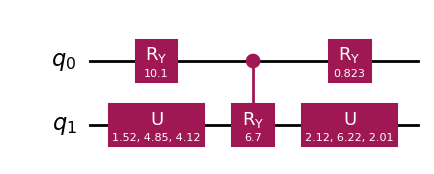

In [18]:
qnn_residual = QNN(residual=True) # 参数初始化敏感，需要多实例化几次
qnn_residual.qnn.draw()

In [19]:
trained_qnn_residual = train_model(epochs=30, model=qnn_residual, dataset=dataset_y1_omega2)

0.09173481166362762
0.051802776753902435
0.10934893041849136
0.08815070241689682
0.06877987831830978
0.053568869829177856
0.08969490230083466
0.10739152878522873
0.14124566316604614
0.016635224223136902
0.051447153091430664
0.02286412939429283
0.10692979395389557
0.06377590447664261
0.05652991682291031
0.04324452951550484
0.03855745121836662
0.022687751799821854
0.05153614282608032
0.05053173378109932
0.06904420256614685
0.0489683672785759
0.05511012673377991
0.039910756051540375
0.004728779196739197
0.03342832624912262
0.041711803525686264
0.07136449217796326
0.021264247596263885
0.022458292543888092
0.004519673064351082
0.04809771850705147
0.07399716973304749
0.04438144341111183
0.0404416061937809
0.03523246943950653
0.035225339233875275
0.04820694029331207
0.026450559496879578
0.02290455251932144
0.0382840521633625
0.03295015171170235
0.026828959584236145
0.0072849891148507595
0.03028581663966179
0.026465613394975662
0.06898471713066101
0.009184819646179676
0.037079066038131714
0.02

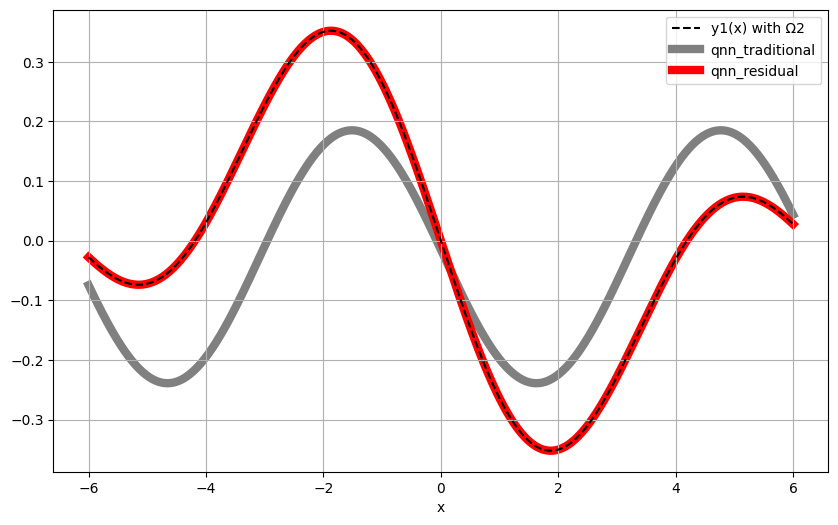

In [20]:
plot_predictions(dataset_y1_omega2,  label_dataset='y1(x) with Ω2',
                 trained_model=[trained_qnn_traditional, trained_qnn_residual],
                 label_model=['qnn_traditional', 'qnn_residual'])


# 实验3（dataset_y2_omega2）

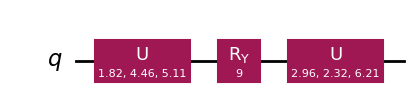

In [21]:
qnn_traditional = QNN(residual=False)
qnn_traditional.qnn.draw()


In [22]:
trained_qnn_traditional = train_model(epochs=30, model=qnn_traditional, dataset=dataset_y2_omega2)

0.06727191805839539
0.04210291802883148
0.031114861369132996
0.042618848383426666
0.049205075949430466
0.04033120721578598
0.0425262376666069
0.02129725180566311
0.027944032102823257
0.03543689846992493
0.0383184552192688
0.03484807908535004
0.012010222300887108
0.022978588938713074
0.0449027456343174
0.017695555463433266
0.03143619745969772
0.036067526787519455
0.029484456405043602
0.02518453262746334
0.02265230379998684
0.028136536478996277
0.023298736661672592
0.01499970443546772
0.025265973061323166
0.03083282709121704
0.023684747517108917
0.028155524283647537
0.02422885037958622
0.027757417410612106
0.024950936436653137
0.029689915478229523
0.04523826390504837
0.02568972483277321
0.03557627275586128
0.034231871366500854
0.025446269661188126
0.030472973361611366
0.03473981097340584
0.02522583119571209
0.02992573380470276
0.03209483623504639
0.014523714780807495
0.017514491453766823
0.024028997868299484
0.03893829137086868
0.03486083075404167
0.03391248732805252
0.027731657028198242

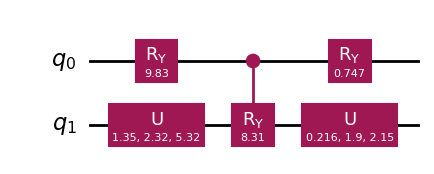

In [23]:
qnn_residual = QNN(residual=True) # 参数初始化敏感，需要多实例化几次
qnn_residual.qnn.draw()

In [24]:
trained_qnn_residual = train_model(epochs=30, model=qnn_residual, dataset=dataset_y2_omega2)

0.06335732340812683
0.04441758617758751
0.06749268621206284
0.08556421101093292
0.0943300724029541
0.05934613198041916
0.05289309099316597
0.06514405459165573
0.04629551246762276
0.058064717799425125
0.059117235243320465
0.06894318759441376
0.06187569350004196
0.09527839720249176
0.07160644233226776
0.05292503535747528
0.06011435016989708
0.09862761944532394
0.045295726507902145
0.07115204632282257
0.030624307692050934
0.03389513120055199
0.043687205761671066
0.0657891035079956
0.041962724179029465
0.031117519363760948
0.03627358004450798
0.04042894393205643
0.0492258295416832
0.0732761025428772
0.04476724565029144
0.05380301922559738
0.03749370202422142
0.03072969987988472
0.024010879918932915
0.05542951077222824
0.02556726522743702
0.04764708876609802
0.038065142929553986
0.056275952607393265
0.04973069578409195
0.0398038886487484
0.03922295197844505
0.04579518362879753
0.028317563235759735
0.05356164649128914
0.03190324828028679
0.03606100007891655
0.034699197858572006
0.01461841817

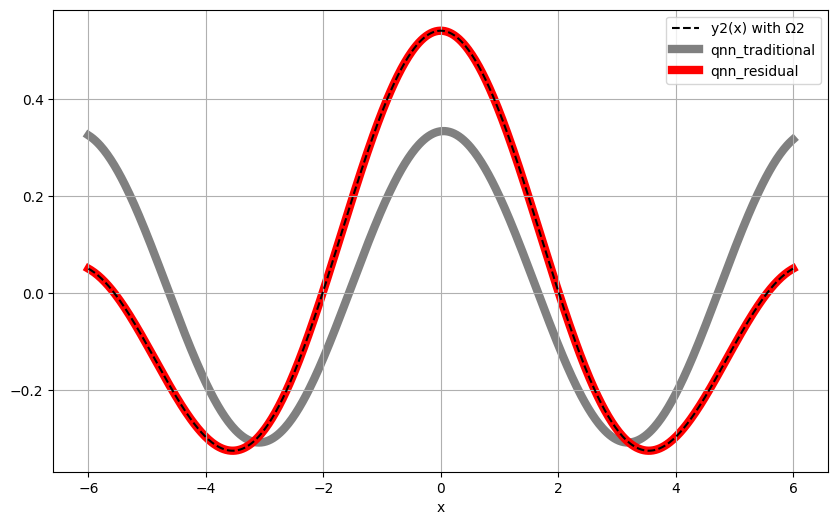

In [25]:
plot_predictions(dataset_y2_omega2,  label_dataset='y2(x) with Ω2',
                 trained_model=[trained_qnn_traditional, trained_qnn_residual],
                 label_model=['qnn_traditional', 'qnn_residual'])
